# Оглавление
1. [Задание](#introduction1)
2. [Импорт библиотек и данных](#paragraph11)
3. [Проверка корректности работы системы сплитования](#paragraph12)  
    3.1. [Первичная оценка](#subparagraph121)  
    3.2 [АА-тест](#subparagraph122)  
4. [Вывод](#paragraph13) 

## 1. Задание <a name="Introduction1"></a>

Предоставлены данные АА-теста с 2022-10-26 по 2022-11-01 включительно. 

**Цель:** проверить работает ли система сплитования корректно.  

**План:**  
- Проводим симуляцию, как будто делаем 10000 АА-тестов;
- На каждой итерации формируются подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы;  
- Проводится сравнение этих подвыборок t-testом;
- Делаем вывод о корректности системы сплитования по результатам исследования.  

За критический уровень статистической значимости взято значение 0.05  

**Описание данных:**  
- *user_id* - уникальный идентификатор пользователя  
- *action* - действие пользователя (view или like)  
- *time* - время осуществления действия пользователя  
- *exp_group* - номер экспериментальной группы

## 2. Импорт библиотек и данных <a name="paragraph11"></a>

Импортируем библиотеки

In [1]:
import pandas as pd
import pandahouse as ph
import random
from scipy import stats as st
import matplotlib.pyplot as plt 
import seaborn as sns

Импортируем данные

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': password,
    'user': user,
    'database': 'simulator_20221120'
}

In [3]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-10-26' and '2022-11-01'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

In [4]:
df = ph.read_clickhouse(q, connection=connection)

## 3. Проверка корректности работы системы сплитования <a name="paragraph12"></a>

### 3.1. Первичная оценка <a name="subparagraph121"></a>

In [5]:
# Посмотрим на число пользователей в каждой группе
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


Количество пользователей в экспериментальных группах примерно одинаковое, т.е. размеры групп примерно одинаковые.

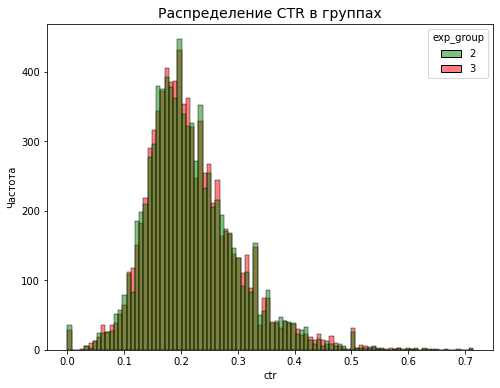

In [6]:
# Взглянем на графики CTR по группам:
plt.figure(figsize=(8,6))
plt.title("Распределение CTR в группах",size=14)
plt.ylabel("Частота",size=10)
groups = sns.histplot(data = df,
                      x = 'ctr',
                      hue = 'exp_group',
                      palette = ['g','r'],
                      alpha = 0.5,
                      kde = False)

Как видно из графика, распределения CTR в экспериментальных группах 2 и 3 похожи.

### 3.2. АА-тест <a name="subparagraph122"></a>

Проведём симуляцию 10 000 АА-тестов.  
На каждой итерации будем проводить t-тест для подвыборок без повторения в 500 юзеров из 2 и 3 экспериментальной группы.    
**Нулевая гипотеза H₀:** средние значения ctr во 2 и в 3 экспериментальных группах равны.  
**Альтернативная гипотеза H₁:** средние значения ctr во 2 и в 3 экспериментальных группах не равны.


In [7]:
p_values = []
for _ in range(10000):
    a1 = random.sample(list(df[df.exp_group==2].user_id),500) #подвыборкa без повторения из 2 эксп.гр.
    a2 = random.sample(list(df[df.exp_group==3].user_id),500) #подвыборкa без повторения из 3 эксп.гр.
    result = st.ttest_ind(df.query("user_id in @a1").ctr,
                          df.query("user_id in @a2").ctr,
                          equal_var=False) #t-test
    p_values.append(result.pvalue) #добавление p-value в список значений p-values

1. Строим гистограмму распределения получившихся 10 000 значений p-value

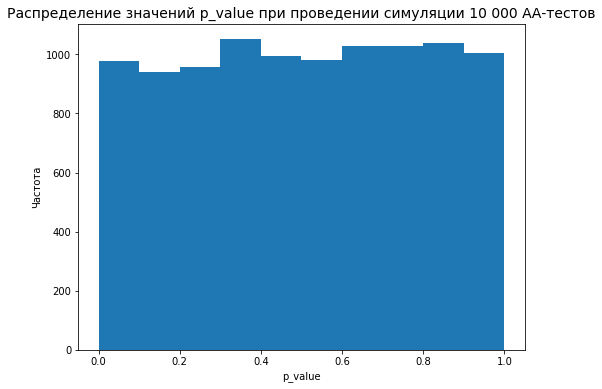

In [8]:
plt.figure(figsize=(8,6))
plt.title("Распределение значений p_value при проведении симуляции 10 000 АА-тестов",size=14)
plt.ylabel("Частота",size=10)
plt.xlabel("p_value",size=10)
groups = plt.hist(p_values)

Исходя из графика, бОльшая часть полученных значений p_value больше 0.05 (критического уровня статистической значимости)

2. Сосчитаем процент p-values, которые оказались меньше либо равны 0.05 (т.е. процент тех значений p_value, когда можем отвергнуть нулевую гипотезу)

In [9]:
(pd.DataFrame(p_values, columns=['p_val'])
.query('p_val <= 0.05')
.count()
 /len(p_values)
)

p_val    0.048
dtype: float64

Таким образом, вероятность получить статистически значимые различия между 2 и 3 эксперим.группами приблизительно равна 0.05, т.е. только в 5% случаев мы можем получить стат.значимые различия между этими группами. Тем самым, можем утверждать о корректности работы системы сплитования.

## 4. Вывод <a name="paragraph13"></a>

Учитывая проведенный анализ, можем утверждать,что наша система сплитования работает корректно.